# 0. Package Imports

#### Python packages import

In [9]:
import os
import shutil
import time
import re
import string
import numpy as np
import pandas as pd
import pickle as pk

from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint

import random
from random import randint

import sklearn.datasets
import sklearn.metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# import autosklearn.classification

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

final_dir = 'Final/'
output_dir = 'Output/'

proc_nr_csv_out_fpath = output_dir+'Proc_Nr_2010a2020.csv'
proc_nr_csv_fpath = final_dir+'Proc_Nr_2010a2020.csv'
proc_data_csv_fpath = final_dir+'Proc_Julgados_Prot_2010a2020.csv'
docs_df_csv_fpath = final_dir+'Documentos_2010to2020.csv'
pchv_df_csv_fpath = final_dir+'Palavras_Chave.csv'
tab_he_csv_fpath = final_dir+'Tabela_HE.csv'
masked_df_csv_fpath = final_dir+'masked_df.csv'

raw_df_pkl_fpath = final_dir+'raw_df.pkl'
docs_df_pkl_fpath = final_dir+'docs_df.pkl'
pchv_df_pkl_fpath = final_dir+'pchv_df.pkl'
res_df_pkl_fpath = final_dir+'res_df.pkl'
out_df_pkl_fpath = final_dir+'out_df.pkl'
high_df_pkl_fpath = final_dir+'high_df.pkl'
prev_df_pkl_fpath = final_dir+'prev_df.pkl'
admjud_df_pkl_fpath = final_dir+'admjud_df.pkl'
decl_df_pkl_fpath = final_dir+'decl_df.pkl'
conf_df_pkl_fpath = final_dir+'conf_df.pkl'
vol_df_pkl_fpath = final_dir+'vol_df.pkl'
prior_df_pkl_fpath = final_dir+'prior_df.pkl'
mcf_df_pkl_fpath = final_dir+'mcf_df.pkl'
jud_df_pkl_fpath = final_dir+'jud_df.pkl'
arr_df_pkl_fpath = final_dir+'arr_df.pkl'
rffp_df_pkl_fpath = final_dir+'rffp_df.pkl'
solid_df_pkl_fpath = final_dir+'solid_df.pkl'
geral_df_pkl_fpath = final_dir+'geral_df.pkl'
he_dics_pkl_fpath = final_dir+'he_dics.pkl'
ml_dics_pkl_fpath = final_dir+'ml_dics.pkl'

#### Load variables and dataframes from files

In [2]:
raw_df = pd.read_pickle(raw_df_pkl_fpath)

with open(he_dics_pkl_fpath, 'rb') as f:
    pk_dic = pk.load(f)
attrib_dic = pk_dic['attrib_dic']
he_dic = pk_dic['he_dic']
tab_to_feature_dic = pk_dic['tab_to_feature_dic']
attrib_to_features_dic = pk_dic['attrib_to_features_dic']

# 3. FEATURE ENGINEERING

## 3.1. Classifying features

In [3]:
index_col = ['proc_nr']
categ_cols = ['Tipo Processo','Descrição Origem SIEF','Quantidade Volumes','Prioridade do Processo']
numeric_cols = ['days_in_load']
binary_cols = ['Indicador de Concessão de Medida Cautelar Fiscal','Indicador se Existe Processo de Acompanhamento Judicial',\
       'Indicador se Existe Processo de Arrolamento','Indicador se Existe Processo de Representação para Fins Penais',\
       'Indicador Contribuinte Diferenciado','Indicador Contribuinte Especial','Indicador de Optante pelo DTE',\
       'Indicador de Solicitante com Moléstia Grave','Indicador se Existe Responsável Solidário/Subsidiário',\
       'Indicador se Solicitada Prioridade Baseada no Estatuto do Idoso','Número Lote Atual']
quantity_cols = ['Processos Vinculados']
range_cols = ['Valor do Processo']
qtd_folhas_cols = ['qtd_folhas_fisco', 'qtd_folhas_contestacao', 'qtd_folhas_total']
tributo_group_cols = ['Tributo']
infracao_group_cols = ['Infração']
contrib_group_cols = ['Tipo Contribuinte','Porte Contribuinte']
act_group_cols = ['ACT - Área de Concentração Temática','ACT - Origem','ACT - Tributo','ACT - Código','ACT - Código do Tema','ACT - Código Completo']
target_col = ['he_float']
exclude_cols = ['Grupo Processo','Subtipo Processo','Assunto COMPROT','Controle Processual','Data do Protocolo',\
       'Indicador se Existe Nota de Processo','Idade Contribuinte','Data Sessão DRJ','Equipe de Análise/Apreciação DRJ',\
       'Indicador de Julgamento em Lote','Data Distribuição Última','dt_protocolo','dt_pauta_drj','equipe_pauta',\
       'dt_distr_drj','dt_sessao_drj','he_efet','he_ajust','he_saido']

## 3.2. Categorical Features

In [4]:
categ_names = {
    'proc_nr':'proc_nr',
    'Tipo Processo':'proc_tipo',
    'Descrição Origem SIEF':'desc_sief',
    'Quantidade Volumes':'volume_nr',
    'Prioridade do Processo':'prior',
}
categ_df = raw_df[categ_cols].copy()
categ_df.rename(columns=categ_names, inplace=True)
categ_df['desc_sief'].fillna('N/D', inplace=True) # 3009 rows with 'desc_sief'=NaN
categ_df.describe(include='all')

,proc_tipo,desc_sief,volume_nr,prior
count,50178,50178,50178,50178
unique,8,14,10,4
top,LANÇAMENTO,Notificação de Lançamento Eletrônica,0001,SEM PRIORIDADE
freq,29466,11863,50101,46574


In [5]:
tipo_groups = {
    'RESTITUIÇÃO':['RESTITUIÇÃO'],
    'LANÇAMENTO':['LANÇAMENTO'],
    'REST/COMP/REEMB/RESS':['RESSARCIMENTO','RESTITUIÇÃO/COMPENSAÇÃO/REEMBOLSO','RESTITUIÇÃO/RESSARCIMENTO/COMPENSAÇÃO'],
    'OUTROS TRIBUTÁRIO':['OUTROS TRIBUTÁRIO'],
    'OUTROS PREVIDENCIÁRIO':['OUTROS PREVIDENCIÁRIO'],
    'OUTROS ADMINISTRATIVO/JUDICIAL':['OUTROS ADMINISTRATIVO/JUDICIAL'],
}
def getTipoClass(x, groups=tipo_groups):
    c = ''
    for k,v in groups.items():
        if x in v:
            c = k
            break
    return c
categ_df['proc_tipo'] = raw_df['Tipo Processo'].apply(getTipoClass)
categ_df.describe(include='all')

,proc_tipo,desc_sief,volume_nr,prior
count,50178,50178,50178,50178
unique,6,14,10,4
top,LANÇAMENTO,Notificação de Lançamento Eletrônica,0001,SEM PRIORIDADE
freq,29466,11863,50101,46574


In [6]:
desc_sief_groups = {
    'PERDCOMP Manual':['MANUAL PER/DCOMP','MANUAL DCOMP','MANUAL PER'],
    'PER/DCOMP Eletrônico':['AUTOMÁTICO DCOMP','AUTOMÁTICO PER', 'AUTOMÁTICO PER/DCOMP'],
    'AUTO de Infração Eletrônico':['AUTO de Infração Eletrônico'],
    'Notificação de Lançamento Eletrônica':['Notificação de Lançamento Eletrônica'],
    'Ação Fiscal':['Ação Fiscal'],
    'Declaração':['Declaração'],
    'Revisão Interna':['Revisão Interna'],
    'Confissão Espontânea':['Confissão Espontânea'],
    'N/D':['N/D'],
}
def getSiefClass(x, groups=desc_sief_groups):
    c = 'N/D'
    for k,v in groups.items():
        if x in v:
            c = k
            break
    return c
categ_df['desc_sief'] = categ_df['desc_sief'].apply(getSiefClass)

In [7]:
vol_groups = {
    '1':['0001','1'],
    '2a5':['0002','0003','0004','0005'],
    '6+':['0006','0007','0008','0009','0026']
}
def getVolClass(x, groups=vol_groups):
    c = 'N/D'
    for k,v in groups.items():
        if x in v:
            c = k
            break
    return c
categ_df['volume_nr'] = categ_df['volume_nr'].apply(getVolClass)
categ_df.describe(include='all')

,proc_tipo,desc_sief,volume_nr,prior
count,50178,50178,50178,50178
unique,6,9,3,4
top,LANÇAMENTO,PER/DCOMP Eletrônico,1,SEM PRIORIDADE
freq,29466,14732,50126,46574


## 3.3. Group Features

### 3.3.1.'trib_group' and 'tab_he' Group Features

#### 'trib_group' table column

In [8]:
trib_df = raw_df[tributo_group_cols].copy()
trib_df.rename(columns={'Tributo':'trib_group'}, inplace=True)
count_list = list(trib_df['trib_group'].value_counts())
trib_list = list(trib_df['trib_group'].value_counts().index)
trib_groups = {
    'MULDI':['MULDI','MULDI PREV'],
    'IRPF':['IRPF','IRPF, MULDI'],
    'IRPJ':['IRPJ','CSLL','IRPJ, CSLL','IRPJ,CSLL, MULDI'],
    'PIS/COFINS':['PIS/COFINS','PIS','COFINS','COFINS, PIS','COFINS, PIS, MULDI','PIS, COFINS','PASEP'],
    'IRRF':['IRRF','IRRF, MULDI'],
    'IPI':['IPI'],
    'CP PATRONAL':['CP PATRONAL','CP PATRONAL, TERCEIROS','CP PATRONAL, CP SEGURADO, TERCEIROS','CP PATRONAL, CP SEGURADO','TERCEIROS','CP PATRONAL, MULDI PREV',\
        'CP PATRONAL, CP SEGURADO, TERCEIROS, MULDI PREV','CP SEGURADO','CP PATRONAL, TERCEIROS, MULDI PREV','CP PATRONAL, CP SEGURADO, MULDI PREV',\
        'TERCEIROS, MULDI PREV',', CP SEGURADO','CP SEGURADO, MULDI PREV',', CP PATRONAL','CP SEGURADO, TERCEIROS','CP PATRONAL,'],
    'SIMPLES':['SIMPLES','SIMPLES NAC'],
    'OUTROS':['IRPJ, COFINS, PIS, CSLL','II, IPI, COFINS, PIS','II','II, IPI, COFINS, PIS, MULDI','CSRF','IOF','ITR','II, COFINS, PIS, MULDI','II, COFINS, PIS',\
        'IRPJ, IRRF, CSLL','II, MULDI','IRPJ, IRRF, COFINS, PIS, CSLL','IPI, COFINS, PIS','II, IPI, MULDI','CIDE REM','II, IPI','IPI, MULDI','COSIRF',\
        'IRPJ, COFINS, PIS, CSLL, MULDI','IPI, COFINS, PIS, MULDI','IE','IRPJ, COFINS, CSLL','II, IPI, COFINS','CIDE COM','IRRF, CSRF','COFINS, PIS, CSLL',\
        'II, IPI, PIS, COFINS','IRPJ, IRRF, COFINS, PIS, CSLL, MULDI','CP PATRONAL, IRPJ, COFINS, PIS, CSLL','COFINS, CSLL','IRPJ, COFINS, PIS',\
        'II, PIS, COFINS','REFIS','II, IPI, COFINS, MULDI','IRRF, COFINS, PIS, CSRF','IRPJ, IPI, CSLL','IRPJ, IRRF, IOF, CSLL','IRRF, COFINS, MULDI',\
        'AFRMM','PIS, COFINS, IRPJ, CSLL, II','CONT PREV, IPI, COFINS, PIS','ITR, IRPJ, IRRF, COFINS, PIS, CSLL, MULDI, CSRF','IRRF, COFINS, PIS, MULDI',\
        'IRPJ, IRRF, IOF, COFINS, PIS, CSLL','COFINS, CSRF','IRPJ, IRRF, IOF, COFINS, PIS','MULDI, CIDE REM','IRRF, CSLL','IRPJ, CSLL, COFINS, PIS',\
        'IRPJ, IPI, COFINS, PIS, CSLL','MULDI, REG TRIB SIMPL','IRPJ, IOF, CSLL','II, IPI, COFINS, PIS, AFRMM','SIMPLES, IRPJ, COFINS, PIS, CSLL',\
        'IRRF, COFINS, PIS, CSLL','IRRF, COFINS, PIS','IRPJ, IRRF, IOF, COFINS, PIS, CSLL, CSRF, CIDE REM','CP PATRONAL, IRPJ, IPI, COFINS, PIS, CSLL',\
        'CPMF','IRPJ, PIS, CSLL','IPI, PIS','IRPJ, IRRF, CSLL, MULDI','IRRF, IOF, CSRF','SIMPLES, IRPJ, COFINS, PIS, CSLL, SIMPLES NAC']
}
def getTributoClass(x, trib_groups=trib_groups):
    c = 'OUTROS'
    for k,v in trib_groups.items():
        if x in v:
            c = k
            break
    return c
trib_df['trib_group'] = trib_df['trib_group'].apply(getTributoClass)

#### 'tab_he' column

In [9]:
def getTabHE(tributo):
    he_tab = ''
    for k, v in tab_to_feature_dic.items():
        p_list = v['patterns']
        for p in p_list:
            if p in tributo:
                he_tab = k
                break
    if he_tab=='':
        he_tab = '9_0'
    return he_tab

def includeTabHEInDf(df):
    he_tab_list, det_he_list = [], []
    for index, row in df.iterrows():
        # tributo = row['Tributo']
        tributo = row['trib_group']
        if not pd.isnull(tributo):
            he_tab = getTabHE(tributo)
        he_tab_list.append(he_tab)
    return he_tab_list, det_he_list

he_tab_list, det_he_list = includeTabHEInDf(trib_df)
trib_df['he_tab'] = np.array(he_tab_list)
trib_df.describe(include='all')

,trib_group,he_tab
count,50178,50178
unique,9,8
top,MULDI,2_0
freq,13084,21994


### 3.3.2.'Infração' Group Feature

In [10]:
infracao_df = raw_df[['Infração']].copy()
infr_nr_df = infracao_df['Infração'].value_counts()
categs = list(infr_nr_df[infr_nr_df.values>=100].index)
len(categs)

16

In [11]:
infracao_df = raw_df[['Infração']].copy()
infr_nr_df = infracao_df['Infração'].value_counts()
infr_groups = {
    'DEDUÇÃO INDEVIDA DE DESPESAS':[
        'DEDUÇÃO INDEVIDA DE DESPESAS MÉDICAS',
        'DEDUÇÃO INDEVIDA DE PENSÃO ALIMENTÍCIA JUDICIAL',
        'DEDUÇÃO INDEVIDA COM DESPESA DE INSTRUÇÃO',
        'DEDUÇÃO INDEVIDA DE PENSÃO ALIMENTÍCIA JUDICIAL, DEDUÇÃO INDEVIDA DE DESPESAS MÉDICAS',
        'DEDUÇÃO INDEVIDA COM DESPESA DE INSTRUÇÃO, DEDUÇÃO INDEVIDA DE DESPESAS MÉDICAS',
        'DEDUÇÃO INDEVIDA COM DEPENDENTES',
    ],
    'NÃO PRESTAÇÃO INFORMAÇÃO TRANSPORTE':[
        'NÃO PRESTAÇÃO DE INFORMAÇÃO SOBRE VEÍCULO OU CARGA TRANSPORTADA, OU SOBRE OPERAÇÕES QUE EXECUTAR',
    ],
    'FALTA OU ATRASO GFIP':[
        'FALTA OU ATRASO NA ENTREGA DA GFIP',
    ],
    'COMPENSAÇÃO INDEVIDA EFETUADA EM DECLARAÇÃO':[
        'COMPENSAÇÃO INDEVIDA EFETUADA EM DECLARAÇÃO PRESTADA PELO SUJEITO PASSIVO',
    ],
    'COMPENSAÇÃO INDEVIDA IRRF':[
        'COMPENSAÇÃO INDEVIDA DE IMPOSTO DE RENDA RETIDO NA FONTE',
    ],
    'OMISSÃO DE RENDIMENTOS':[
        'OMISSÃO DE RENDIMENTOS DE ALUGUÉIS RECEBIDOS DE PESSOAS FÍSICAS - DIMOB',
        'OMISSÃO DE RENDIMENTOS RECEBIDOS DE PESSOA JURÍDICA',
        'OMISSÃO DE RENDIMENTOS DO TRABALHO COM VÍNCULO E/OU SEM VÍNCULO EMPREGATÍCIO',
    ],
    'RENDIMENTOS INDEVID. ISENTOS MOLÉSTIA':[
        'RENDIMENTOS INDEVIDAMENTE CONSIDERADOS COMO ISENTOS POR MOLÉSTIA GRAVE - NÃO COMPROVAÇÃO DA MOLÉSTIA OU SUA CONDIÇÃO DE APOSENTADO, PENSIONISTA OU REFORMADO',
    ],
    'INSUFICIÊNCIA DE RECOLHIMENTO':[
        'INSUFICIÊNCIA DE RECOLHIMENTO',
    ],
    'PERDIMENTO MERCADORIA':[
        'MERCADORIA SUJEITA A PERDIMENTO - NÃO LOCALIZADA, CONSUMIDA OU REVENDIDA',
    ],
    'OUTROS':list(infr_nr_df[infr_nr_df.values<100].index)
}
def getInfracaoClass(x, groups=infr_groups):
    c = 'OUTROS'
    for k,v in groups.items():
        if x in v:
            c = k
            break
    return c

infracao_df.rename(columns={'Infração':'infracao_group'}, inplace=True)
infracao_df['infracao_group'] = infracao_df['infracao_group'].apply(getInfracaoClass)
infracao_df.describe(include='all')

,infracao_group
count,50178
unique,10
top,OUTROS
freq,34319


### 3.3.3. ['Tipo Contribuinte', 'Porte Contribuinte'] joint group Feature

In [12]:
tp_contr_df = raw_df[contrib_group_cols].copy()
tp_contr_df['contrib_group'] = ''
for index,row in tp_contr_df.iterrows():
    contr_group = 'PF'
    if row['Tipo Contribuinte']=='PJ':
        porte = row['Porte Contribuinte']
        if pd.isnull(porte):
            porte = 'Demais'
        contr_group = 'PJ_'+porte
    tp_contr_df.at[index,'contrib_group'] = contr_group
tp_contr_df.drop(columns=['Tipo Contribuinte', 'Porte Contribuinte'], inplace=True)
tp_contr_df.describe(include='all')

,contrib_group
count,50178
unique,4
top,PJ_Demais
freq,26290


### 3.3.4. ['ACT - Área de Concentração Temática', 'ACT - Origem','ACT - Tributo', 'ACT - Código', 'ACT - Código do Tema', 'ACT - Código Completo'] Group Feature

In [14]:
### NOT USING ACT AT FIRST, redundant with other thematic features

## 3.4. Binary Features

In [15]:
binary_names = {
    'Indicador de Concessão de Medida Cautelar Fiscal':'MCF',
    'Indicador se Existe Processo de Acompanhamento Judicial':'Jud',
    'Indicador se Existe Processo de Arrolamento':'Arr',
    'Indicador se Existe Processo de Representação para Fins Penais':'RFFP',
    'Indicador Contribuinte Diferenciado':'CD',
    'Indicador Contribuinte Especial':'CE',
    'Indicador de Optante pelo DTE':'DTE',
    'Indicador de Solicitante com Moléstia Grave':'MolGrv',
    'Indicador se Existe Responsável Solidário/Subsidiário':'Solid',
    'Indicador se Solicitada Prioridade Baseada no Estatuto do Idoso':'Idoso',
    'Número Lote Atual':'Lote',
}
bin_df = raw_df[binary_cols].copy()
bin_df.rename(columns=binary_names, inplace=True)

#### Fulfill missing with 'N' and replacing lot number with 'S' 

In [16]:
bin_df.fillna('N', inplace=True)
bin_df['Lote'] = bin_df['Lote'].apply(lambda x: 'N' if x=='N' else 'S')
bin_df.describe(include='all')

,MCF,Jud,Arr,RFFP,CD,CE,DTE,MolGrv,Solid,Idoso,Lote
count,50178,50178,50178,50178,50178,50178,50178,50178,50178,50178,50178
unique,2,2,2,2,2,2,2,2,2,2,2
top,N,N,N,N,N,N,N,N,N,N,N
freq,50151,50030,49346,48749,42090,45478,31573,49431,49338,48294,47324


## 3.5. Numeric Quantity Features to Ranges

#### Número de processos vinculados

In [17]:
vinc_groups = {
    '0':['0'],
    '1a5':['1', '2', '3', '4', '5'],
    '6a10':['6', '7', '8', '9', '10'],
    '11a100':['11', '12', '13', '14', '15','16', '17', '18', '19', '20','21', '22'],
}
def getVincClass(x, groups=vinc_groups):
    c = '0'
    if pd.isnull(x):
        c = '0'
    else:
        x = str(len(x.split(',')))
        for k,v in groups.items():
            if x in v:
                c = k
                break
    return c
vinc_df = raw_df[['Processos Vinculados']].copy()
vinc_df.rename(columns={'Processos Vinculados':'qtt_proc_vinc'}, inplace=True)
vinc_df['qtt_proc_vinc'] = vinc_df['qtt_proc_vinc'].apply(getVincClass)
vinc_df.describe(include='all')

,qtt_proc_vinc
count,50178
unique,4
top,0
freq,31742


#### Valor do Processo

In [18]:
range_dic = {'Zero':0., 'Baixo':0.01, 'Medio':2808.31, 'Alto':9693.62, 'Altissimo':115682.60}
def getValClass(x, range_dic=range_dic):
    c = 4
    for k,v in range_dic.items():
        if x>=v:
            c = k
    return c

val_df = raw_df[range_cols].copy()
val_df.rename(columns={'Valor do Processo':'proc_val'}, inplace=True)
val_df['proc_val'] = val_df['proc_val'].apply(getValClass).astype(str)
val_df.describe(include='all')

,proc_val
count,50178
unique,5
top,Zero
freq,17171


#### Quantidade de Folhas de Documentos

In [19]:
qtd_fls_df = raw_df[qtd_folhas_cols].astype(int).copy()

qtd_folhas_dic = {
    'qtd_folhas_fisco': {
            'de 1 a 1': {'feature':'qtd_folhas_fisco', 'categ':list(range(1,2))},
            'de 2 a 2': {'feature':'qtd_folhas_fisco', 'categ':list(range(2,3))},
            'de 3 a 5': {'feature':'qtd_folhas_fisco', 'categ':list(range(3,6))},
            'de 6 a 15': {'feature':'qtd_folhas_fisco', 'categ':list(range(6,15))},
            'de 16 em diante': {'feature':'qtd_folhas_fisco', 'categ':list(range(15,qtd_fls_df['qtd_folhas_fisco'].max()+1))},
    },
    'qtd_folhas_contestacao': {
            'de 1 a 1': {'feature':'qtd_folhas_contestacao', 'categ':list(range(1,2))},
            'de 2 a 4': {'feature':'qtd_folhas_contestacao', 'categ':list(range(2,5))},
            'de 5 a 10': {'feature':'qtd_folhas_contestacao', 'categ':list(range(5,11))},
            'de 11 a 20': {'feature':'qtd_folhas_contestacao', 'categ':list(range(11,21))},
            'de 21 em diante': {'feature':'qtd_folhas_contestacao', 'categ':list(range(21,qtd_fls_df['qtd_folhas_contestacao'].max()+1))},
    },
    'qtd_folhas_total': {
            'de 1 a 50': {'feature':'qtd_folhas_total', 'categ':list(range(1,51))},
            'de 51 a 100': {'feature':'qtd_folhas_total', 'categ':list(range(51,101))},
            'de 101 a 500': {'feature':'qtd_folhas_total', 'categ':list(range(101,501))},
            'de 501 a 1000': {'feature':'qtd_folhas_total', 'categ':list(range(501,1000))},
            'de 1001 em diante': {'feature':'qtd_folhas_total', 'categ':list(range(1000,qtd_fls_df['qtd_folhas_total'].max()+1))},
    },
}

for att in qtd_folhas_dic.keys():
    qtd_categ = att[11:]+'_fls_categ'
    qtd_fls_df[qtd_categ] = ''
for idx in qtd_fls_df.index:
    for att in qtd_folhas_dic.keys():
        qtd_categ = att[11:]+'_fls_categ'
        qtd = int(qtd_fls_df.at[idx, att])
        categ = ''
        for k,v in qtd_folhas_dic[att].items():
            if qtd in v['categ']:
                categ = k
                qtd_fls_df.at[idx, qtd_categ] = categ
                break
        if categ=='' and qtd==0:
            qtd_fls_df.at[idx, qtd_categ] = '0'
qtd_fls_df.describe(include='all')

,qtd_folhas_fisco,qtd_folhas_contestacao,qtd_folhas_total,fisco_fls_categ,contestacao_fls_categ,total_fls_categ
count,50178.000000,50178.000000,50178.000000,50178,50178,50178
unique,NaN,NaN,NaN,6,6,5
top,NaN,NaN,NaN,0,de 21 em diante,de 101 a 500
freq,NaN,NaN,NaN,21856,17535,18259
mean,12.366974,35.635318,527.628542,NaN,NaN,NaN
std,172.926976,163.134801,5535.888289,NaN,NaN,NaN
min,0.000000,0.000000,15.000000,NaN,NaN,NaN
25%,0.000000,3.000000,56.000000,NaN,NaN,NaN
50%,1.000000,12.000000,98.000000,NaN,NaN,NaN
75%,5.000000,30.000000,227.000000,NaN,NaN,NaN


### 3.6. Target Feature 'he_float'

In [20]:
he_df = raw_df[['he_float']].astype(float).copy()
he_df.describe(include='all')

,he_float
count,50178.000000
mean,11.619730
std,11.337041
min,0.630000
25%,5.000000
50%,8.000000
75%,14.000000
max,147.000000


# 4. COMPUTE FEATURES

#### Compute 'he_calc' from 'qtd_folhas...' in 'calc_df'

In [21]:
def calcHeAttrib(he_str):
    return int(he_str[:he_str.find(':')]) + float(he_str[he_str.find(':')+1:])/60.

calc_df = pd.concat([trib_df, qtd_fls_df, he_df], axis=1, join="inner")
calc_df['he_calc'] = 0.
for feat in qtd_folhas_dic.keys():
    feat_calc = 'he_calc_'+feat[11:]
    calc_df[feat_calc] = 0.

for proc_nr in calc_df.index:
    he_calc = 0.
    for feat in qtd_folhas_dic.keys():
        feat_val = calc_df.at[proc_nr, feat]
        if feat_val==0:
            he_attrib = 0.
        else:
            he_tab = calc_df.at[proc_nr, 'he_tab']
            he_tab_name = tab_to_feature_dic[he_tab]['name']
            for k,v in attrib_to_features_dic[feat].items():
                if feat_val in v['categ']:
                    attrib = k
                    break
            # if attrib=='de 20 a 23':
            #     print(proc_nr, he_tab_name, feat, attrib, he_str, feat_val)
            he_str = he_dic[he_tab_name][feat][attrib]
            he_attrib = calcHeAttrib(he_str)
        calc_df.at[proc_nr, 'he_calc_'+feat[11:]] = he_attrib
        he_calc += he_attrib
    calc_df.at[proc_nr, 'he_calc'] = he_calc
calc_df.drop(columns=qtd_folhas_cols, inplace=True)

#### Define 'he_calc_group' from 'he_calc'

In [22]:
he_calc_classes_dic = {'0':8., '1':16., '2':24., '3':32., '4':1000.}
he_calc_classes = list(he_calc_classes_dic.keys())

he_classes_dic = {'0':8., '1':16., '2':32., '3':1000.}
he_classes = list(he_classes_dic.keys())

def getClass(x, classes):
    c = 0
    for k,v in classes.items():
        if x<=v:
            c = k
            break
    return c

def getHeCalcClass(x, he_calc_groups=he_calc_classes_dic):
    return getClass(x, he_calc_groups)

calc_df['he_calc_group'] = calc_df['he_calc'].apply(getHeCalcClass)
categ_cols = categ_cols + ['he_calc_group']

def getHeClass(x, he_groups=he_classes_dic):
    return getClass(x, he_groups)

calc_df['he_group'] = calc_df['he_float'].apply(getHeClass)

print(calc_df.describe(include=object))

       trib_group he_tab fisco_fls_categ contestacao_fls_categ  \
count       50178  50178           50178                 50178   
unique          9      8               6                     6   
top         MULDI    2_0               0       de 21 em diante   
freq        13084  21994           21856                 17535   

       total_fls_categ he_calc_group he_group  
count            50178         50178    50178  
unique               5             5        4  
top       de 101 a 500             0        0  
freq             18259         34624    26564  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000279F8931748>]],
      dtype=object)

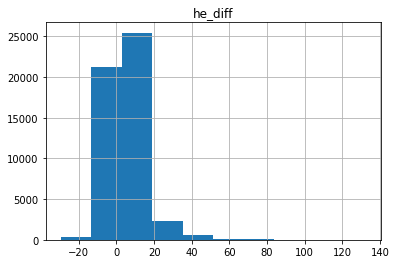

In [23]:
diff_df = calc_df[['he_float', 'he_calc']].copy()
diff_df['he_diff'] = diff_df['he_float'] - diff_df['he_calc']
diff_df.hist(column='he_diff')

# 5. JOINT DATAFRAME AND POPULATION SEGMENTATION

## 5.1. Joint Dataframe 'res_df'

In [24]:
# Concatenação dos dataframes com dados dos processos e palavras-chaves
res_df = pd.concat([categ_df, infracao_df, tp_contr_df, bin_df, vinc_df, val_df, calc_df], axis=1, join="inner")
res_df.to_pickle(res_df_pkl_fpath)
res_df.describe(include=object)

,proc_tipo,desc_sief,volume_nr,prior,infracao_group,contrib_group,MCF,Jud,Arr,RFFP,...,Lote,qtt_proc_vinc,proc_val,trib_group,he_tab,fisco_fls_categ,contestacao_fls_categ,total_fls_categ,he_calc_group,he_group
count,50178,50178,50178,50178,50178,50178,50178,50178,50178,50178,...,50178,50178,50178,50178,50178,50178,50178,50178,50178,50178
unique,6,9,3,4,10,4,2,2,2,2,...,2,4,5,9,8,6,6,5,5,4
top,LANÇAMENTO,PER/DCOMP Eletrônico,1,SEM PRIORIDADE,OUTROS,PJ_Demais,N,N,N,N,...,N,0,Zero,MULDI,2_0,0,de 21 em diante,de 101 a 500,0,0
freq,29466,14732,50126,46574,34319,26290,50151,50030,49346,48749,...,47324,31742,17171,13084,21994,21856,17535,18259,34624,26564


In [25]:
res_df.describe(include=np.number)

,he_float,he_calc,he_calc_fisco,he_calc_contestacao,he_calc_total
count,50178.000000,50178.000000,50178.000000,50178.000000,50178.000000
mean,11.619730,6.720146,0.485239,4.029162,2.205746
std,11.337041,6.980400,1.745859,4.907082,2.569358
min,0.630000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1.800000,0.000000,0.500000,0.500000
50%,8.000000,4.300000,0.000000,2.200000,1.500000
75%,14.000000,9.600000,0.200000,6.100000,2.600000
max,147.000000,61.300000,13.300000,30.000000,18.000000


## 5.2. Segmentation in Deterministic Populations

In [26]:
out_df = res_df[(res_df['he_float']>=80) & (res_df['proc_tipo']=='OUTROS TRIBUTÁRIO')]
out_df.to_pickle(out_df_pkl_fpath)
high_df = res_df[(res_df['he_float']>=80) & (res_df['proc_tipo']!='OUTROS TRIBUTÁRIO')]
high_df.to_pickle(high_df_pkl_fpath)
res_df = res_df.loc[list(set(res_df.index)-set(out_df.index)-set(high_df.index))]

prev_df = res_df[res_df['proc_tipo']=='OUTROS PREVIDENCIÁRIO']
prev_df.to_pickle(prev_df_pkl_fpath)
admjud_df = res_df[res_df['proc_tipo']=='OUTROS ADMINISTRATIVO/JUDICIAL']
admjud_df.to_pickle(admjud_df_pkl_fpath)
res_df = res_df.loc[list(set(res_df.index)-set(prev_df.index)-set(admjud_df.index))]

decl_df = res_df[res_df['desc_sief']=='Declaração']
decl_df.to_pickle(decl_df_pkl_fpath)
conf_df = res_df[res_df['desc_sief']=='Confissão Espontânea']
conf_df.to_pickle(conf_df_pkl_fpath)
res_df = res_df.loc[list(set(res_df.index)-set(decl_df.index)-set(conf_df.index))]

vol_df = res_df[res_df['volume_nr']!='1']
vol_df.to_pickle(vol_df_pkl_fpath)
prior_df = res_df[res_df['prior'].isin(['MEDIA','ALTA'])] # include MAXIMA???
prior_df.to_pickle(prior_df_pkl_fpath)
mcf_df = res_df[res_df['MCF']=='S']
mcf_df.to_pickle(mcf_df_pkl_fpath)
jud_df = res_df[res_df['Jud']=='S']
jud_df.to_pickle(jud_df_pkl_fpath)
arr_df = res_df[res_df['Arr']=='S']
arr_df.to_pickle(arr_df_pkl_fpath)
rffp_df = res_df[res_df['RFFP']=='S']
rffp_df.to_pickle(rffp_df_pkl_fpath)
solid_df = res_df[res_df['Solid']=='S']
solid_df.to_pickle(solid_df_pkl_fpath)
idxs = set(res_df.index)-set(vol_df.index)-set(prior_df.index)-set(mcf_df.index)\
    -set(jud_df.index)-set(arr_df.index)-set(rffp_df.index)-set(solid_df.index)
geral_df = res_df.loc[list(idxs)]
geral_df.to_pickle(geral_df_pkl_fpath)

In [6]:
import pandas as pd
geral_df = pd.read_pickle(geral_df_pkl_fpath)

In [4]:
res_df = pd.read_pickle(res_df_pkl_fpath)
res_df.to_csv(final_dir+'res_df.csv')

## 5.3. Generating Masked Dataframe

In [7]:
symbols = string.ascii_uppercase
cols = ['proc_tipo', 'desc_sief', 'prior', 'infracao_group', 'contrib_group', 'Lote', 'qtt_proc_vinc', 'proc_val', 'trib_group']
mask_dic = {}
for i in range(len(cols)):
    col = cols[i]
    vals = list(geral_df[col].unique())
    col_dic = {}
    for j in range(len(vals)):
        val = vals[j]
        col_dic[val] = symbols[j]
    mask_dic[col] = col_dic
masked_df = geral_df.copy()
masked_df.reset_index(inplace=True)
masked_df.drop(columns=['proc_nr'], inplace=True)
for k, v in mask_dic.items():
    for vk, vv in v.items():
        masked_df[k].replace(vk, vv, inplace=True)
masked_df.to_csv(masked_df_csv_fpath)

# 6. DATA TRANSFORMATION

## Converting string data to numerical and dummy categories

In [29]:
ml_features = ['proc_tipo', 'desc_sief', 'prior', 'CD', 'CE', 'DTE', 'MolGrv', 'Idoso', 'Lote', 'qtt_proc_vinc', 'proc_val',
    'trib_group', 'infracao_group', 'contrib_group', 'fisco_fls_categ', 'contestacao_fls_categ', 'total_fls_categ', 'he_calc_group']
ml_df = masked_df.copy()
X_cat_df = ml_df[ml_features].copy()
X_cat_code_df = pd.DataFrame(index=X_cat_df.index)
for col in X_cat_df.columns:
    X_cat_code_df[col] = X_cat_df[col].astype('category').cat.codes.astype('category')
X_cat_code = X_cat_code_df.to_numpy()
enc_X_cat = OneHotEncoder(categories='auto')
enc_X_cat.fit(X_cat_code)
X_cat_dummy = enc_X_cat.transform(X_cat_code).toarray()

y_num_df = ml_df['he_float']
y_num = y_num_df.to_numpy().reshape(-1, 1)
y_cat_df = ml_df['he_group']
y_cat_code_df = ml_df['he_group'].astype('category').cat.codes.astype('category')
y_cat_code = y_cat_code_df.to_numpy().reshape(-1, 1)
enc_y_cat = OneHotEncoder(categories='auto')
enc_y_cat.fit(y_cat_code)
y_cat_dummy = enc_y_cat.transform(y_cat_code).toarray()

ml_dics = {
    'X_cat_code':X_cat_code,
    'X_cat_dummy':X_cat_dummy,
    'y_num':y_num,
    'y_cat_code':y_cat_code,
    'y_cat_dummy':y_cat_dummy,
}
with open(ml_dics_pkl_fpath, 'wb') as f:
    pk.dump(ml_dics, f)

# 7. MACHINE LEARNING

## 7.1. Dummy Random Classifier (for accuracy level reference)

In [30]:
from sklearn.dummy import DummyClassifier
X, y = X_cat_code, y_cat_code
for ctype in ['most_frequent', 'prior', 'stratified', 'uniform']:
    dummy_clf = DummyClassifier(strategy=ctype)
    dummy_clf.fit(X, y)
    # dummy_clf.predict(np.array(X))
    acc = dummy_clf.score(X, y)
    print(ctype, ' = ', round(100*acc, 0), '%')

most_frequent  =  56.0 %
prior  =  56.0 %
stratified  =  41.0 %
uniform  =  25.0 %


## 7.2. Linear Regression

### 7.2.1. Linear Regression with Numeric Target

In [36]:
X, y = X_cat_dummy, y_num
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
lnr = LinearRegression()
lnr.fit(X_train, y_train)
y_prev = lnr.predict(X_test)
print('*** Desempenho (Coef. Determ. R2) Treinamento = {:.2f}'.format(lnr.score(X_train, y_train)), ' - Desempenho (Coef. Determ. R2) Teste = {:.2f}'.format(lnr.score(X_test, y_test)))

*** Acuracia (Coef. Determ. R2) Treinamento = 0.73  - Acuracia (Coef. Determ. R2) Teste = 0.73


### 7.2.2. Linear Regression with Categorical Target

In [37]:
X, y = X_cat_dummy, y_cat_code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
lnr = LinearRegression()
lnr.fit(X_train, y_train)
y_prev = lnr.predict(X_test)
print('*** Desempenho Treinamento (Coef. Determ. R2) = {:.2f}'.format(lnr.score(X_train, y_train)), ' - Desempenho Teste (Coef. Determ. R2) = {:.2f}'.format(lnr.score(X_test, y_test)))

*** Acuracia Treinamento (Coef. Determ. R2) = 0.69  - Acuracia Teste (Coef. Determ. R2) = 0.70


### 7.2.3. Linear Regression with Dummy Target

In [38]:
X, y = X_cat_dummy, y_cat_dummy
for i in range(y.shape[1]):
    y_vect = y[:,i].T
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    lnr = LinearRegression()
    lnr.fit(X_train, y_train)
    y_prev = lnr.predict(X_test)
    print('*** Etapa {0:d}: Desempenho Treinamento (Coef. Determ. R2) = {1:.2f} - Desempenho Teste (Coef. Determ. R2) = {2:.2f}'.format(i, lnr.score(X_train, y_train), lnr.score(X_test, y_test)))

*** Etapa 0: Acuracia Treinamento (Coef. Determ. R2) = 0.41 - Acuracia Teste (Coef. Determ. R2) = 0.41
*** Etapa 1: Acuracia Treinamento (Coef. Determ. R2) = 0.41 - Acuracia Teste (Coef. Determ. R2) = 0.41
*** Etapa 2: Acuracia Treinamento (Coef. Determ. R2) = 0.41 - Acuracia Teste (Coef. Determ. R2) = 0.41
*** Etapa 3: Acuracia Treinamento (Coef. Determ. R2) = 0.41 - Acuracia Teste (Coef. Determ. R2) = 0.41


## 7.3. Logistic Regression

### 7.3.1. Logistic Regression for each Dummy Target

In [39]:
from sklearn.linear_model import LogisticRegression
X, y = X_cat_code, y_cat_dummy
y_pred_mtx = []
for j in range(y.shape[1]):
    y_vect = y[:,j].T
    X_train, X_test, y_train, y_test = train_test_split(X, y_vect, test_size=0.1, random_state=0)
    lgr = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000, solver='lbfgs')
    lgr.fit(X_train, y_train)
    y_pred = lgr.predict(X_test)
    y_pred_mtx.append(lgr.predict(X))
    print('*** Etapa {0:d}: Acuracia Treinamento = {1:.2f} - Acuracia Teste = {2:.2f}'.format(j, lgr.score(X_train, y_train), lgr.score(X_test, y_test)))

*** Etapa 0: Acuracia Treinamento = 0.84 - Acuracia Teste = 0.83
*** Etapa 1: Acuracia Treinamento = 0.73 - Acuracia Teste = 0.72
*** Etapa 2: Acuracia Treinamento = 0.73 - Acuracia Teste = 0.74
*** Etapa 3: Acuracia Treinamento = 0.82 - Acuracia Teste = 0.81


### 7.3.2. Logistic Regression Sequence for Decrescent Dummy Target

In [40]:
X, y = X_cat_dummy, y_cat_dummy
y_pred_mtx = np.array([[0 for j in range(y.shape[1]+1)] for i in range(y.shape[0])])
X_round, y_round, = X, y
for col_id in range(y_round.shape[1]-1, -1, -1):
    y_vect = y_round[:,col_id].T
    X_train, X_test, y_train, y_test = train_test_split(X_round, y_vect, test_size=0.1, random_state=0)
    lgr = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000, solver='lbfgs')
    lgr.fit(X_train, y_train)
    acc_train = lgr.score(X_train, y_train)
    acc_test = lgr.score(X_test, y_test)
    y_prev = lgr.predict(X_round)
    y_id_list = [j for j in range(len(y_prev)) if y_prev[j]==0]
    X_round, y_round = X_round[y_id_list], y_round[y_id_list]
    y_pred_mtx[:,col_id] = lgr.predict(X)
    print('*** Etapa {0:d} - {1:d} amostras: Acuracia Treinamento = {2:.2f} - Acuracia Teste = {3:.2f}'.format(col_id, int(y_prev.sum()), acc_train, acc_test))

*** Etapa 3 - 4937 amostras: Acuracia Treinamento = 0.92 - Acuracia Teste = 0.92
*** Etapa 2 - 11425 amostras: Acuracia Treinamento = 0.79 - Acuracia Teste = 0.79
*** Etapa 1 - 9452 amostras: Acuracia Treinamento = 0.84 - Acuracia Teste = 0.85
*** Etapa 0 - 16410 amostras: Acuracia Treinamento = 0.79 - Acuracia Teste = 0.79


### 7.3.3. Logistic Regression Multiclass

In [41]:
X, y = X_cat_code, y_cat_code.T[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
lgr = LogisticRegression(multi_class='multinomial', class_weight='balanced', max_iter=10000, solver='lbfgs', random_state=0)
lgr.fit(X_train, y_train)
y_prev = lgr.predict(X_test)
print('*** Acuracia Treinamento = {0:.2f} - Acuracia Teste = {1:.2f}'.format(lgr.score(X_train, y_train), lgr.score(X_test, y_test)))

*** Acuracia Treinamento = 0.67 - Acuracia Teste = 0.67


## 7.4. Naïve Bayes

### 7.4.1. Multinomial Naïve Bayes

In [42]:
X, y = X_cat_dummy, y_cat_code.T[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_prev = mnb.predict(X_test)
print('*** Acuracia Treinamento = {0:.2f} - Acuracia Teste = {1:.2f}'.format(mnb.score(X_train, y_train), mnb.score(X_test, y_test)))

*** Acuracia Treinamento = 0.75 - Acuracia Teste = 0.74


### 7.4.2. Complement Naïve Bayes

In [43]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)
y_prev = cnb.predict(X_test)
print('*** Acuracia Treinamento = {0:.2f} - Acuracia Teste = {1:.2f}'.format(cnb.score(X_train, y_train), cnb.score(X_test, y_test)))

*** Acuracia Treinamento = 0.74 - Acuracia Teste = 0.73


## 7.5. SGD Classifier (SVM)

In [44]:
X, y = X_cat_dummy, y_cat_code.T[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
sgd.fit(X_train, y_train)
y_prev = sgd.predict(X_test)
print('*** Acuracia Treinamento = {0:.2f} - Acuracia Teste = {1:.2f}'.format(sgd.score(X_train, y_train), sgd.score(X_test, y_test)))

*** Acuracia Treinamento = 0.77 - Acuracia Teste = 0.77


## 7.6. Neural Network Multi-layer Perceptron Classifier

## 7.6.1. Neural Network Multi-layer Perceptron Classifier with Unbalanced Sample (original)

In [45]:
X, y = X_cat_dummy, y_cat_code.T[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
mlp = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
mlp.predict_proba(X_test[:1])
print('Acuracia Treinamento = {:.2f}'.format(mlp.score(X_train, y_train)),' *** Acuracia Teste = {:.2f}'.format(mlp.score(X_test, y_test)))

Acuracia Treinamento = 0.88  *** Acuracia Teste = 0.82


## 7.6.2. Neural Network Multi-layer Perceptron Classifier with Balanced Sample

In [46]:
X, y = X_cat_dummy, y_cat_code.T[0]
ros = RandomOverSampler(random_state=0)
X_balanced, y_balanced = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, stratify=y_balanced, random_state=1)
mlp = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
mlp.predict_proba(X_test[:1])
print('Acuracia Treinamento = {:.2f}'.format(mlp.score(X_train, y_train)),' *** Acuracia Teste = {:.2f}'.format(mlp.score(X_test, y_test)))

Acuracia Treinamento = 0.87  *** Acuracia Teste = 0.85


In [47]:
idxs = [[i for i in range(len(y)) if y[i]==j] for j in range(4)]
for i in range(4):
    idxi = idxs[i]
    Xi = X[idxi,:]
    yi = y[idxi]
    print('*** Etapa {0:d} - {1:d} amostras: Acuracia = {2:.2f}'.format(i, len(idxs[i]), mlp.score(Xi, yi)))

*** Etapa 0 - 26273 amostras: Acuracia = 0.91
*** Etapa 1 - 13324 amostras: Acuracia = 0.77
*** Etapa 2 - 6093 amostras: Acuracia = 0.79
*** Etapa 3 - 1425 amostras: Acuracia = 0.98


## 7.7. Random Forest Classifier

In [48]:
X, y = X_cat_dummy, y_cat_code.T[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
rdf = RandomForestClassifier(n_estimators = 100)
rdf.fit(X_train, y_train)
y_prev = rdf.predict(X_test)
print('*** Acuracia Treinamento = {0:.2f} - Acuracia Teste = {1:.2f}'.format(rdf.score(X_train, y_train), rdf.score(X_test, y_test)))

*** Acuracia Treinamento = 0.91 - Acuracia Teste = 0.83


In [49]:
X, y = X_cat_dummy, y_cat_code.T[0]
ros = RandomOverSampler(random_state=0)
X_balanced, y_balanced = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1, random_state=0)
rdf = RandomForestClassifier(n_estimators = 100)
rdf.fit(X_train, y_train)
y_prev = rdf.predict(X_test)
print('*** Acuracia Treinamento = {0:.2f} - Acuracia Teste = {1:.2f}'.format(rdf.score(X_train, y_train), rdf.score(X_test, y_test)))
print('*** Acuracia = {0:.2f}'.format(rdf.score(X, y)))

*** Acuracia Treinamento = 0.91 - Acuracia Teste = 0.89
*** Acuracia = 0.90


In [50]:
idxs = [[i for i in range(len(y)) if y[i]==j] for j in range(4)]
for i in range(4):
    idxi = idxs[i]
    Xi = X[idxi,:]
    yi = y[idxi]
    print('*** Etapa {0:d} - {1:d} amostras: Acuracia = {2:.2f}'.format(i, len(idxs[i]), mlp.score(Xi, yi)))

*** Etapa 0 - 26273 amostras: Acuracia = 0.91
*** Etapa 1 - 13324 amostras: Acuracia = 0.77
*** Etapa 2 - 6093 amostras: Acuracia = 0.79
*** Etapa 3 - 1425 amostras: Acuracia = 0.98


## 7.8. AUTOML Classifier

### 7.8.1. 300s Time Window

In [10]:
X, y = X_cat_dummy, y_cat_code
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

automl_dir = '/tmp/autosklearn_classification_test002_tmp'
if os.path.isdir(automl_dir):
    shutil.rmtree(automl_dir)
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    per_run_time_limit=60,
    tmp_folder=automl_dir,
)
automl.fit(X_train, y_train, dataset_name='he_prediction')

/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


AutoSklearnClassifier(per_run_time_limit=60, time_left_for_this_task=300,
                      tmp_folder='/tmp/autosklearn_classification_test002_tmp')

In [11]:
print(automl.leaderboard())
pprint(automl.show_models(), indent=4)
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

          rank  ensemble_weight               type      cost   duration
model_id                                                               
3            1             0.48  gradient_boosting  0.182489  50.019757
6            2             0.28  gradient_boosting  0.190807  46.215749
5            3             0.16  gradient_boosting  0.199554  18.819011
4            4             0.08      random_forest  0.210188  35.059789
{   3: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7fd00d58fc70>,
           'cost': 0.1824886373381357,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fd00d58f1c0>,
           'ensemble_weight': 0.48,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fd00d58f4f0>,
           'model_id': 3,
           'rank': 1,


### 7.8.2. 1000s Time Window

In [ ]:
X, y = X_cat_dummy, y_cat_code
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

automl_dir = '/tmp/autosklearn_classification_test002_tmp'
if os.path.isdir(automl_dir):
    shutil.rmtree(automl_dir)
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=1000,
    per_run_time_limit=60,
    tmp_folder=automl_dir,
)
automl.fit(X_train, y_train, dataset_name='he_prediction')

/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


Error: Canceled future for execute_request message before replies were done

In [ ]:
print(automl.leaderboard())
pprint(automl.show_models(), indent=4)
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

          rank  ensemble_weight           type      cost   duration
model_id                                                           
2            1              1.0  random_forest  0.176571  29.491303
{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7fd00b63f250>,
           'cost': 0.17657147757482206,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fd00ba1e970>,
           'ensemble_weight': 1.0,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fd00b63f100>,
           'model_id': 2,
           'rank': 1,
           'sklearn_classifier': RandomForestClassifier(max_features=8, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)}}
Accuracy score: 0.8262161473809322


In [55]:
with open(ml_dics_pkl_fpath, 'rb') as f:
    ml_dics = pk.load(f)
mls = list(ml_dics.keys())
print(mls)

['X_cat_code', 'X_cat_dummy', 'y_num', 'y_cat_code', 'y_cat_dummy']


In [62]:
ml = mls[0]
ml_mtx = ml_dics[ml]
print(ml, ' - ', ml_mtx.shape)
print(ml_mtx)

X_cat_code  -  (47115, 18)
[[0 0 0 ... 5 0 0]
 [0 1 0 ... 2 4 0]
 [0 0 0 ... 2 4 0]
 ...
 [1 3 0 ... 2 4 0]
 [0 2 0 ... 5 1 2]
 [1 3 0 ... 4 2 1]]


In [63]:
ml = mls[1]
ml_mtx = ml_dics[ml]
print(ml, ' - ', ml_mtx.shape)
print(ml_mtx)

X_cat_dummy  -  (47115, 79)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [64]:
ml = mls[2]
ml_mtx = ml_dics[ml]
print(ml, ' - ', ml_mtx.shape)
print(ml_mtx)

y_num  -  (47115, 1)
[[ 4.]
 [ 4.]
 [ 4.]
 ...
 [ 4.]
 [25.]
 [16.]]


In [65]:
ml = mls[3]
ml_mtx = ml_dics[ml]
print(ml, ' - ', ml_mtx.shape)
print(ml_mtx)

y_cat_code  -  (47115, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [2]
 [1]]


In [66]:
ml = mls[4]
ml_mtx = ml_dics[ml]
print(ml, ' - ', ml_mtx.shape)
print(ml_mtx)

y_cat_dummy  -  (47115, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
